<a href="https://colab.research.google.com/github/CorleoneAppolonia/PMP-2024/blob/main/EXAMEN/subiectul_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np

df = pd.read_csv("date_alegeri_turul2.csv")

X = df[['Varsta', 'Sex', 'Educatie', 'Venit']]
y = df['Vot']

# -----------------------------------------------------------------
# 1) Modelul COMPLET (cu toate variabilele)
#    Definire si sampling in InferenceData (cu log likelihood)
# -----------------------------------------------------------------
with pm.Model() as model_complet:
    alpha = pm.Normal("alpha", mu=0, sigma=10)

    beta_varsta = pm.Normal("beta_varsta", mu=0, sigma=1)
    beta_sex    = pm.Normal("beta_sex",    mu=0, sigma=1)
    beta_educ   = pm.Normal("beta_educ",   mu=0, sigma=1)
    beta_venit  = pm.Normal("beta_venit",  mu=0, sigma=1)

    logits = (
        alpha
        + beta_varsta * X['Varsta']
        + beta_sex    * X['Sex']
        + beta_educ   * X['Educatie']
        + beta_venit  * X['Venit']
    )

    p = pm.math.sigmoid(logits)

    like = pm.Bernoulli("like", p, observed=y)

    # Facem sample si stocam intr-un InferenceData
    idata_complet = pm.sample(
        2000, tune=1000,
        return_inferencedata=True,            # <--- CHEIE
        idata_kwargs={"log_likelihood": True},# <--- CHEIE
        random_seed=42
    )

# -----------------------------------------------------------------
# 2) Modelul SIMPLU (doar Varsta si Sex, de ex.)
# -----------------------------------------------------------------
with pm.Model() as model_simplu:
    alpha2       = pm.Normal("alpha2", mu=0, sigma=10)
    beta_varsta2 = pm.Normal("beta_varsta2", mu=0, sigma=2)
    beta_sex2    = pm.Normal("beta_sex2",    mu=0, sigma=2)

    logits2 = alpha2 + beta_varsta2 * X['Varsta'] + beta_sex2 * X['Sex']
    p2 = pm.math.sigmoid(logits2)

    like2 = pm.Bernoulli("like2", p2, observed=y)

    idata_simplu = pm.sample(
        2000, tune=1000,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
        random_seed=42
    )

# -----------------------------------------------------------------
# 3) Compararea cu WAIC (sau LOO)
# -----------------------------------------------------------------
cmp = az.compare(
    {
        "model_complet": idata_complet,
        "model_simplu":  idata_simplu
    },
    ic="waic",         # criteriul de informație: WAIC
    method="stacking"  # modul de combinare a modelelor (greutățile)
)
print(cmp)



Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━  76% 0:00:03 / 0:00:08

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━  81% 0:00:03 / 0:00:09

               rank   elpd_waic    p_waic  elpd_diff  weight         se  \
model_complet     0 -211.640506  4.755660   0.000000     1.0  12.686580   
model_simplu      1 -248.858849  2.823957  37.218343     0.0  12.491419   

                    dse  warning scale  
model_complet  0.000000    False   log  
model_simplu   8.442806    False   log  


In [2]:
post_simplu = idata_simplu.posterior.stack(samples=("chain","draw"))

alpha2_samples = post_simplu["alpha2"].values  # shape (n_samples,)
beta_varsta2_samples = post_simplu["beta_varsta2"].values
beta_sex2_samples    = post_simplu["beta_sex2"].values

# Definim un range de varsta (ex: 18..80), si Sex=0 sau 1
varsta_range = np.linspace(18, 80, 200)

# Pentru fiecare punct, calculam probabilitatea p = sigmoid(alpha2 + bV*varsta + bS*sex).
# Daca Sex=0, de ex.:
p_mean_femeie = []
for v in varsta_range:
    # Calculam p la fiecare esantion
    logits_s = alpha2_samples + beta_varsta2_samples*v + beta_sex2_samples*0
    p_s      = 1/(1 + np.exp(-logits_s))  # sigmoid
    p_mean_femeie.append(p_s.mean())  # media posteriorului

# Similar pentru Sex=1 (barbat).
p_mean_barbat = []
for v in varsta_range:
    logits_s = alpha2_samples + beta_varsta2_samples*v + beta_sex2_samples*1
    p_s      = 1/(1 + np.exp(-logits_s))
    p_mean_barbat.append(p_s.mean())


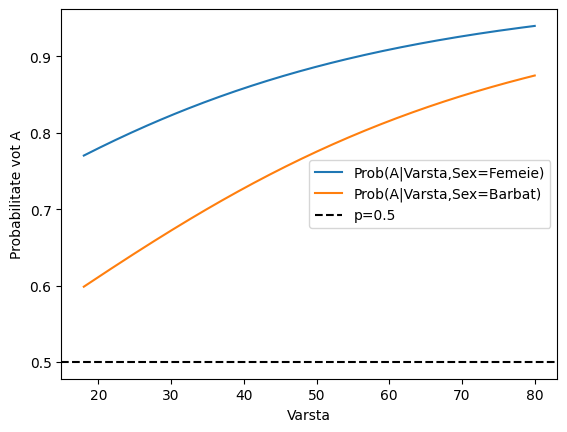

In [3]:
import matplotlib.pyplot as plt
plt.plot(varsta_range, p_mean_femeie, label="Prob(A|Varsta,Sex=Femeie)")
plt.plot(varsta_range, p_mean_barbat, label="Prob(A|Varsta,Sex=Barbat)")
plt.axhline(0.5, color="k", linestyle="--", label="p=0.5")
plt.legend()
plt.xlabel("Varsta")
plt.ylabel("Probabilitate vot A")
plt.show()
